In [18]:
#####
#preliminary functions
#####

using Printf
using Plots
using LinearAlgebra

######
#WA mc routine

const L       = 10             # linear size of lattice
const temps   = 1.6:-0.1:0.1  # temperatures to sample
const nt = length(temps)      #number of temperatures
#the 4 different bond directions on the lattice
dir_list = [[1,0,1], [0,1,1], [-1,0,-1], [0,-1,-1]] 
#index 1,2 is the direction in x,y 
#index 3 is the default link value in that direction
#link_default = [1,1,-1,-1]

#J= 0 (indexed 1) can go to J=1 (indexed 2) and J=-1 (indexed 3)
#J = \pm 1 can only go to J=0 (truncation)

all_x = ones(Int32, 2*L, 2*L)
all_y = ones(Int32, 2*L, 2*L)

for i in 1:2:2*L
    all_x[:,i] = zeros(Int32, 2*L)
    all_y[i,:] = zeros(Int32, 2*L)
end

function sweep(nv, ratio, all_map) 
    
    i = 0
    #winding = 0.0
    worm_num = 0
    #energy = 0.0

    while i <= nv
        #pick a I = M site
        worm_num += 1
        Ix = 2*rand(1:L)
        Iy = 2*rand(1:L)
        Mx = Ix
        My = Iy
        cond = true
        wind_x = 0.0
        wind_y = 0.0
        count_this_worm = 0
        while cond
            #choose a bond direction
            dir_link = dir_list[rand(1:4)]
            link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
            link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
            link_val = all_map[link_x, link_y] #that's the current value there
            prop_add = dir_link[3]
            
            new_val = link_val + prop_add
            #test_prop = (absolute(new_val) < 2) #truncate updates
            #if test_prop
            
            deltaS = (ratio)*(new_val^2 - link_val^2) 
            #random number and acceptance test
            p = rand()
            barrier = minimum([1, exp(-deltaS)])
            if (p < barrier)
                all_map[link_x, link_y] = new_val
                Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
                My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
                i += 1   
                #wind_x += dir_link[1]     
                #wind_y += dir_link[2]

            end

            cond = !(Ix == Mx && Iy == My)
            #print(" ", cond, "\n")
        end
        
        
        #winding += 0.5*(sum(all_map.*all_x)/L)^2 + (sum(all_map.*all_y)/L)^2
        #energy += (ratio)*(sum(all_map)/L)^2
            
    end
    
    #display([worm_num, nv])
    
    #return winding/worm_num, energy/worm_num
end

#testing
#all_map_test = sweep(10, 0.9, zeros(Int32,2*10,2*10))
#it is nonzero = it works

function measureWorm(ratio, all_map)
    #pick a I = M site
    worm_num += 1
    Ix = 2*rand(1:L)
    Iy = 2*rand(1:L)
    Mx = Ix
    My = Iy
    cond = true
    while cond
        #choose a bond direction
        dir_link = dir_list[rand(1:4)]
        link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
        link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
        link_val = all_map[link_x, link_y] #that's the current value there
        prop_add = dir_link[3]

        new_val = link_val + prop_add
        #test_prop = (absolute(new_val) < 2) #truncate updates
        #if test_prop

        deltaS = (ratio)*(new_val^2 - link_val^2) 
        #random number and acceptance test
        p = rand()
        barrier = minimum([1, exp(-deltaS)])
        if (p < barrier)
            all_map[link_x, link_y] = new_val
            Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
            My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
            #count_this_worm += 1

            #display("accept")
        end

        cond = !(Ix == Mx && Iy == My)
        #print(" ", cond, "\n")
    end

    winding = 0.5*(sum(all_map.*all_x)/L)^2 + (sum(all_map.*all_y)/L)^2
    energy = (ratio)*(sum(all_map)/L)^2
    #display([worm_num, nv])
    
    return winding, energy
end


measureWorm (generic function with 1 method)

In [20]:
######
#WA mc routine for the XY model
#####

n_sweep = 30*L^2             # number of sweeps between sampling
n_therm = 200*L^2           # number of sweeps to thermalize
n_data  = 200*L^2            # number of data samples per temperature

#empty lists of measures to fill
et = []                  # array to append average energy at each T
chi = []                 # "                      susceptibility
cv = []                 # "                      specific heat
rho = []               # "                      winding numbers = stiffness
#store the correlation function G(I - M) for all temperatures
g_maps = zeros(Int32, L, L, nt)

#initialize the configuration - double the number of indices, bonds live on even indices
all_map = zeros(Int32,2*L, 2*L) 

all_stiff_t = zeros(Float64, n_data, nt)


for ti in 1:nt              # loop over temperatures
    T = temps[ti]
    β = 1/T
    ratio = 1/(β)
    
    bonds_list = zeros(Float64, n_data)
    ene_list = zeros(Float64, n_data)
    mag_list = zeros(Float64, n_data)
    stiff_list = zeros(Float64, n_data)
    g_maps_temperature = zeros(Int32, L, L)
    
    #initialize the starting configuration as either the zero-filled one
    #or the last map obtained after the measurements from the previous high-temperature
    sweep(n_therm, ratio, all_map)    # thermalize the lattice
    for m = 1:n_data        # take n_data measurements w/ n_sweep 
        #sweep(n_sweep, ratio, all_map)   
        wave, ene = measureWorm(ratio, all_map)  #to add - green's functions
        #g_maps_temperature += g_meas
        ene_list[m] = -ene
        #mag_list[i] = sum(g_meas)
        #bonds_list[i] = sum(all_map)
        stiff_list[m] = T*wave
    end    
    #winding, energy = sweep(n_data, ratio, all_map)    # thermalize the lattice
    #push!(et, energy)
    #push!(all_wind, T*winding)
    all_stiff_t[:,ti] = stiff_list
    en_ave = sum(ene_list)/n_data
    cv_ave = sqrt(sum((ene_list .- en_ave).^2) / (n_data - 1))
    stiff_ave = sum(stiff_list)/n_data
    push!(et,-en_ave)                # add to the list    
    push!(cv, cv_ave)                # add to the list
    push!(rho, stiff_ave)
    
    @printf("T = %8.3f  stiff = %8.3f E = %8.3f \n", T, stiff_ave, en_ave)
    flush(stdout)
end

T =    1.600  stiff =    0.000 E =    0.000 
T =    1.500  stiff =    0.001 E =   -0.001 
T =    1.400  stiff =    0.000 E =    0.000 
T =    1.300  stiff =    0.006 E =   -0.007 
T =    1.200  stiff =    0.009 E =   -0.011 
T =    1.100  stiff =    0.044 E =   -0.058 
T =    1.000  stiff =    0.155 E =   -0.207 
T =    0.900  stiff =    0.361 E =   -0.489 
T =    0.800  stiff =    0.584 E =   -0.790 
T =    0.700  stiff =    0.705 E =   -0.935 
T =    0.600  stiff =    0.738 E =   -0.978 
T =    0.500  stiff =    0.750 E =   -1.006 
T =    0.400  stiff =    0.748 E =   -1.012 
T =    0.300  stiff =    0.745 E =   -1.024 
T =    0.200  stiff =    0.750 E =   -0.988 
T =    0.100  stiff =    0.743 E =   -0.985 


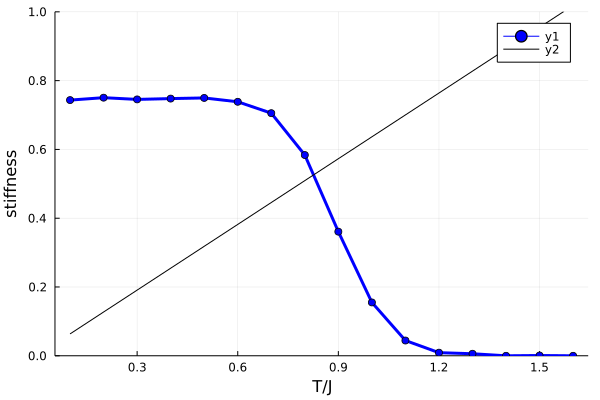

In [23]:
#temps = temps[end:-1:1]
#all_wind = all_wind[end:-1:1]
plot(temps, rho, lw = 3, shape = :circle, color = :blue, markersize = 4, ylims = (0,3))
plot!(temps, 2*temps/pi, lw = 1, color = :black, ylims = (0,1))
xlabel!("T/J")
ylabel!("stiffness")

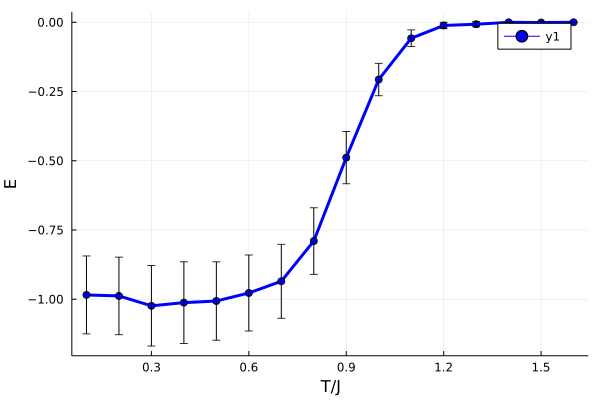

In [24]:
plot(temps, -et, yerr = cv/L, lw = 3, shape = :circle, color = :blue, markersize = 4)
xlabel!("T/J")
ylabel!("E")

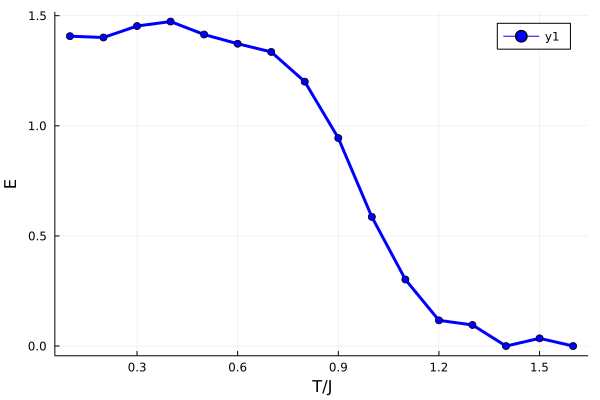

In [29]:
plot(temps, cv, lw = 3, shape = :circle, color = :blue, markersize = 4)
xlabel!("T/J")
ylabel!("E")

In [13]:
#test
if false
    all_map = zeros(Int32, 2*L, 2*L)
    sweep(200, 0.6, all_map)
    v1 = sum(all_map)

    g_map = zeros(Int32, L, L)
    g_map += measureWorm(0.9, all_map, g_map)
    v2 = sum(all_map)
    display(g_map)
end

In [31]:
######
#WA mc routine for the XY model
#####

n_sweep = 10*L^2             # number of sweeps between sampling
n_therm = 50*L^2           # number of sweeps to thermalize
n_data  = 500*L^2            # number of data samples per temperature

#empty lists of measures to fill
et = []                  # array to append average energy at each T
chi = []                 # "                      susceptibility
cv = []                 # "                      specific heat
nlink = []               # "                      number of active bonds
#store the correlation function G(I - M) for all temperatures
g_maps = zeros(Int32, L, L, nt)

#initialize the configuration - double the number of indices, bonds live on even indices
all_map = zeros(Int32,2*L, 2*L) 

for ti in 1:nt              # loop over temperatures
    T = temps[ti]
    β = 1/T
    ratio = (tanh(β))
    
    bonds_list = zeros(Float64, n_data)
    ene_list = zeros(Float64, n_data)
    mag_list = zeros(Float64, n_data)
    g_maps_temperature = zeros(Int32, L, L)
    
    #initialize the starting configuration as either the zero-filled one
    #or the last map obtained after the measurements from the previous high-temperature
    sweep(n_therm, ratio, all_map)    # thermalize the lattice
    for i = 1:n_data        # take n_data measurements w/ n_sweep 
        #sweep(n_sweep, ratio, all_map)   
        g_meas = measureWorm(ratio, all_map)
        g_maps_temperature += g_meas
        ene_list[i] = (g_meas[1,2] + g_meas[2,1]+ g_meas[1,L] + g_meas[L,1])/(2)
        mag_list[i] = sum(g_meas)
        bonds_list[i] = sum(all_map)
    end
    
    g_maps[:,:,ti] = g_maps_temperature
    num_Z = g_maps_temperature[1,1]
    en_ave = sum(ene_list)/num_Z
    cv_ave = sqrt(sum((ene_list .- en_ave).^2) / (num_Z - 1))
    push!(et,-en_ave)                # add to the list    
    push!(cv, cv_ave)                # add to the list
    chi_ave = sum(mag_list)/num_Z
    push!(chi, chi_ave)
    #display(g_map/num_Z)
    @printf("%8.3f  %8.3f \n", T, -en_ave)
    flush(stdout)
end

   4.000    -0.968 
   3.900    -0.981 
   3.800    -1.001 
   3.700    -1.020 
   3.600    -1.038 
   3.500    -1.058 
   3.400    -1.078 
   3.300    -1.105 
   3.200    -1.132 
   3.100    -1.161 
   3.000    -1.195 
   2.900    -1.228 
   2.800    -1.273 
   2.700    -1.314 
   2.600    -1.370 
   2.500    -1.430 
   2.400    -1.511 
   2.300    -1.634 
   2.200    -1.759 
   2.100    -1.833 
   2.000    -1.875 
   1.900    -1.915 
   1.800    -1.942 
   1.700    -1.959 
   1.600    -1.967 
   1.500    -1.981 
   1.400    -1.986 
   1.300    -1.992 
   1.200    -1.994 
   1.100    -1.995 
   1.000    -1.998 
   0.900    -1.995 
   0.800    -2.000 
   0.700    -2.002 
   0.600    -2.000 
   0.500    -2.001 
   0.400    -2.001 
   0.300    -2.003 
   0.200    -2.003 
   0.100    -2.001 


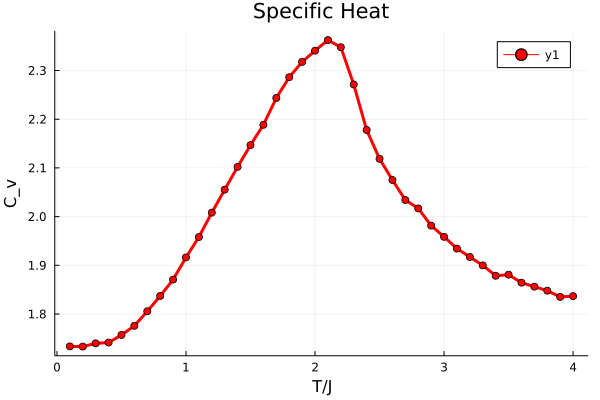

In [32]:
plot(temps, cv, title = "Specific Heat", lw = 3, shape = :circle, color = :red, markersize = 4)
xlabel!("T/J")
ylabel!("C_v")


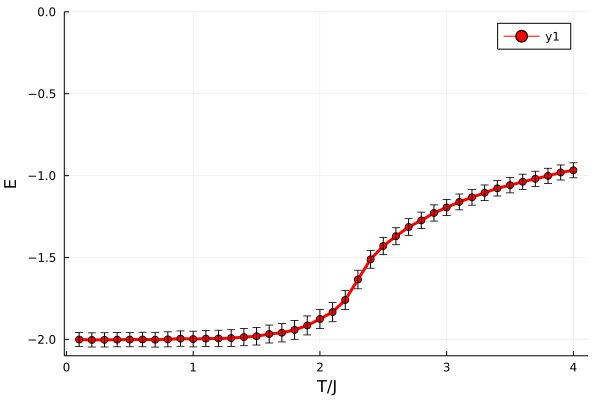

In [33]:
plot(temps, et, yerr = cv/L, lw = 3, shape = :circle, color = :red, markersize = 4, ylims = (-2.1, 0))
xlabel!("T/J")
ylabel!("E")

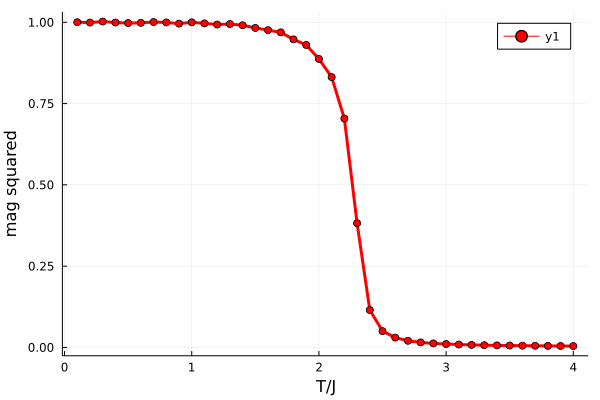

In [34]:
plot(temps, chi/L^2, lw = 3, shape = :circle, color = :red, markersize = 4)
xlabel!("T/J")
ylabel!("mag squared")

In [18]:
#######
#practice code
#######

if false

    L       = 10             # linear size of lattice
    hL = Int(L/2)
    #n_sweep = 20             # number of sweeps between sampling
    n_therm = 1000           # number of sweeps to thermalize
    n_meas  = 5000            # number of data samples per temperature
    temps   = 8.0:-0.3:0.1;   # temperatures to sample
    nt = length(temps)

    e1 = Array(1:n_data)     # array to hold energy measurements (fixed T)
    m1 = Array(1:n_data)     # array to hold magnetization measurements (fixed T)
    et = []                  # array to append average energy at each T
    mt = []                  # "                      magnetizations
    chi = []

    nlink = []
    #sites = zeros(Int32,L, L) 
    #bonds = zeros(Int32,2*L, 2*L) 
    #bond2site = zeros(Int32,2*L, 2*L, 2) 
    #site2bond = zeros(Int32, L, L, 4) 

    g_maps = zeros(Int32, L, L, nt)

    all_map = zeros(Int32,2*L, 2*L) #g_map = zeros(Int32,L, L) 
    #g_count = zeros(Int32,L, L) 
    #β = 10
    dir_list = [[1,0], [0,1], [-1,0], [0,-1]] 

    #list_visit_x = []
    #list_visit_y = []

    for ti in 1:nt              # loop over temperatures
        T = temps[ti]
        β = 1/T
        ratioB = (tanh(β))



        #g_count = zeros(Int32,L, L) 

        ####
        #thermalization
        ####

        therm = n_therm*L^2
        i = 0

        all_map_therm = all_map

        while i <= therm

            #println("doing iter #", i)
            #pick a I = M site
            Ix = 2*rand(1:L)
            Iy = 2*rand(1:L)
            #all_map[Ix, Iy] = -1  #to see visited sites
            #print("x,y = ", [Ix, Iy], "\n")

            Mx = Ix
            My = Iy

            cond = true

            while cond
                dir_link = dir_list[rand(1:4)]

                link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
                link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
                link_val = all_map_therm[link_x, link_y]
                #print("link considered ", [link_x, link_y], "\n")

                p = rand()
                barrier = minimum([1, ratioB^(1 - 2*link_val)])
                if (p < barrier)
                    all_map_therm[link_x, link_y] = 1 - link_val
                    Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
                    My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
                    i += 1
                end

                cond = !(Ix == Mx && Iy == My)
                #print(" ", cond, "\n")
            end
        end

        ######
        #some measurement
        ######

        maxiter = n_meas*L^2

        val_prod = 1.0
        N_bond = 0
        i = 0
        #num_Z = 0
        g_map = zeros(Int32,L, L) 

        while i<=maxiter

            all_map = all_map_therm
            #println("doing iter #", i)
            #pick a I = M site
            Ix = 2*rand(1:L)
            Iy = 2*rand(1:L)
            #all_map[Ix, Iy] = -1  #to see visited sites
            #print("x,y = ", [Ix, Iy], "\n")

            Mx = Ix
            My = Iy

            dist_M_to_I = [0,0] 

            cond = true

            g_map_visit = zeros(Int32,L, L) 

            while cond
                N_bond_in = 0
                dir_link = dir_list[rand(1:4)]

                link_x = 1 + mod(Mx - 1 + dir_link[1], 2*L)
                link_y = 1 + mod(My - 1 + dir_link[2], 2*L)
                link_val = all_map[link_x, link_y]
                #print("link considered ", [link_x, link_y], "\n")

                p = rand()
                barrier = minimum([1, (tanh(β))^(1 - 2*link_val)])
                if (p < barrier)
                    all_map[link_x, link_y] = 1 - link_val
                    Mx = 1 + mod(Mx - 1 + 2*dir_link[1], 2*L)
                    My = 1 + mod(My - 1 + 2*dir_link[2], 2*L)
                    dist_M_to_I += dir_link
                    g_x = 1 + mod(dist_M_to_I[1], L)
                    g_y = 1 + mod(dist_M_to_I[2], L)

                    #g_x = Int(mod(Ix/2 - Mx/2 + 1, L + 1))
                    #g_y = Int(mod(Iy/2 - My/2 + 1, L + 1))
                    #old func
                    #g_map_visit[g_x, g_y] += 1
                    #if g_map_visit[g_x,g_y] == 1
                    #    g_map[g_x, g_y] += 1
                    #end
                    g_map[g_x, g_y] += 1
                    i += 1
                    N_bond_in += 1
                    #println("updated link ")
                    #all_map[Mx, My] = -1 #to see visited sites
                    #val_prod = val_prod*(tanh(β))^(1 - 2*link_val)
                    #masha - ira
                    #vec = distance([Ix,Iy], [Mx, My])
                    #g_map[1+vec[1], 1+vec[2]] += val_prod
                    #g_count[1+vec[1], 1+vec[2]] += 1.0



                    #push!(list_visit_x, Mx)
                    #push!(list_visit_y, My)
                end

                cond = !(Ix == Mx && Iy == My)
                #print(" ", cond, "\n")

                #if cond == false && N_bond_in != 0
                #    num_Z += 1
                #end
            end

            N_bond += sum(all_map)
        end

        num_Z = g_map[1,1]
        push!(nlink, N_bond/num_Z)
        en_ave = (g_map[1,2] + g_map[2,1] + g_map[1,L] + g_map[L,1])/(2*num_Z) 
        push!(et,-en_ave)                # add to the list
        push!(chi, sum(g_map)/maxiter)

        display(g_map/num_Z)
        g_maps[:,:,ti] = g_map
        @printf("%8.3f  %8.3f \n", T, -en_ave)
        flush(stdout)

    end
end